In [2]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
class StoryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        story = row['story']
        programming_concept = row['programming_concept']
        inputs = self.tokenizer.encode("Once upon a time, " + story, add_special_tokens=True, max_length=self.max_length, truncation=True)
        return {
            'inputs': torch.tensor(inputs, dtype=torch.long),
            'programming_concept': programming_concept
        }

In [3]:
# Preprocess data and return dataset
def data_preprocessing(dataset_path, max_length=128):
    data = pd.read_excel(dataset_path)
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    return StoryDataset(data, tokenizer, max_length)

In [4]:
# Train the model
def model_training(dataset, num_epochs=3, learning_rate=5e-5, batch_size=4):
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader) * num_epochs)
    
    model.train()
    losses = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        for batch in dataloader:
            inputs = batch['inputs'].to(device)
            labels = inputs.clone()
            outputs = model(input_ids=inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        epoch_loss = total_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Average Loss: {epoch_loss}")
    
    return model, losses

In [5]:
# Generate a story
def generate_story(programming_concept, genre, model_path="fine_tuned_model", max_length=100):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    
    prompt = f"Once upon a time, "
    input_ids = tokenizer.encode(prompt, return_tensors="pt", max_length=max_length, truncation=True)
    
    # Ensure attention mask is set to 1 for input tokens and 0 for padding tokens
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)
    
    # Ensure pad_token_id is set to eos_token_id
    model.config.pad_token_id = tokenizer.eos_token_id
    
    output = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,  # You can remove this parameter if do_sample=True
        do_sample=True,   # Enable sampling to use temperature
        attention_mask=attention_mask
    )
    
    generated_story = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_story

Starting data preprocessing...
Data preprocessing completed.

Training the model...


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Average Loss: 1.3620015599279323
Epoch 2/3
Average Loss: 0.4837690794315094
Epoch 3/3
Average Loss: 0.28339987754439694
Model training completed.

Saving the model...
Model saved.

Generating a story...


Enter the programming concept:  loop
Enter the genre:  adventure


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Story:
Once upon a time,  Title: The Whispering Stones
Chapter 1: The Enchanted Forest
Deep within the Whispering Stones, where ancient trees whispered secrets to those who listened, three young explorers—Aria, Leo, and Ava—set out to explore the unexplored depths. Guided by rumors of ancient healing spells and hidden treasures, they ventured deeper into the forest's depths, where tales of forgotten guardians and forgotten civilizations echoed through the trees.
Chapter 2: The

Calculating accuracy...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Accuracy: 0.0 %


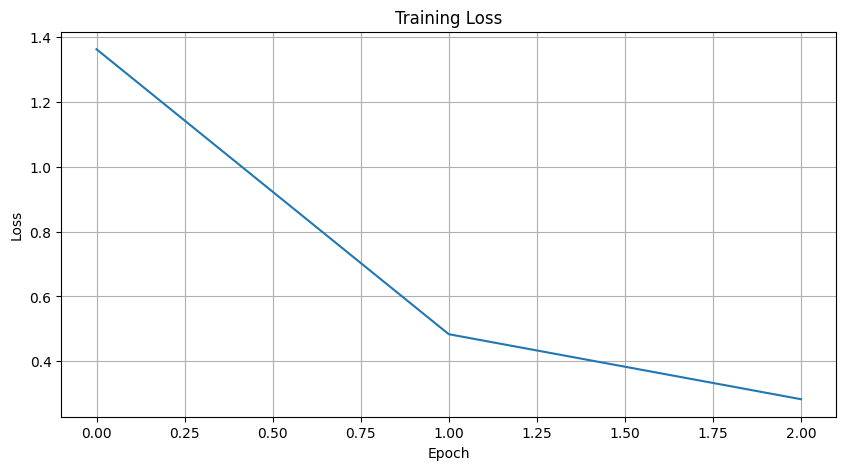


Comparing original and generated stories:

Original Story 1: Title: The Magical Adventure of Codeville
Chapter 1: The Mysterious Cave
In the magical land of Codeville, four friends - Ruby the Rabbit, Python the Parrot, Java the Jaguar, and Scratch the Squirrel, stumbled upon a mysterious cave during one of their adventures. Curiosity sparkled in their eyes as they approached the cave entrance.
Chapter 2: The Locked Door
Upon entering the cave, the friends discovered a locked door with strange symbols and instructions written in a magical code. Ruby, being the fastest, volunteered to decipher the code. The instructions were clear: "Hop forward twice, then turn left, and finally, hop forward three times." Ruby followed the sequence, and to their amazement, a magical key appeared, unlocking the door.
Chapter 3: The Enchanted Chest
As the door creaked open, the friends found themselves in a magical chamber with a treasure chest guarded by a friendly dragon named Loop. To open the chest, t

In [6]:
# Main function
def main():
    dataset_path = "Programming_Stories.xlsx"
    model_path = "fine_tuned_model"
    
    print("Starting data preprocessing...")
    dataset = data_preprocessing(dataset_path)
    print("Data preprocessing completed.")
    
    print("\nTraining the model...")
    model, losses = model_training(dataset)
    print("Model training completed.")
    
    print("\nSaving the model...")
    model.save_pretrained(model_path)
    print("Model saved.")
    
    print("\nGenerating a story...")
    programming_concept = input("Enter the programming concept: ")
    genre = input("Enter the genre: ")
    story = generate_story(programming_concept, genre, model_path=model_path)
    print("\nGenerated Story:")
    print(story)

if __name__ == "__main__":
    main()

In [1]:
# Print Accuracy
data = pd.read_excel("Programming_Stories.xlsx")
generated_stories = []
for idx, row in data.iterrows():
    generated_story = generate_story(row['programming_concept'], row['genre'], model_path="fine_tuned_model")
    generated_stories.append(generated_story)

accuracy = sum(1 for x, y in zip(data['story'], generated_stories) if x == y) / len(data) * 100
print("\nModel Accuracy:", accuracy, "%")

NameError: name 'pd' is not defined